In [15]:
import sys
sys.path.append('../')

import torch
import segmentation_models_pytorch as smp
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import onnxruntime as ort

from src.config import config, val_augmentation
from src.tools import read_rgb_img
from src.config import NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH
from src.constants import TORCH_FILE, ONNX_FILE

DEVICE = 'cpu'

state_dict = torch.load(TORCH_FILE)
model = smp.Unet(encoder_name=config.model_kwargs["encoder_name"],
                 encoder_weights=config.model_kwargs["encoder_weights"],
                 classes=NUM_CLASSES,
                 aux_params={'pooling': 'avg', 'dropout': 0.2, 'classes': NUM_CLASSES})
model.load_state_dict(state_dict)
_ = model.to(DEVICE)
_ = model.eval()

(380, 615, 3)


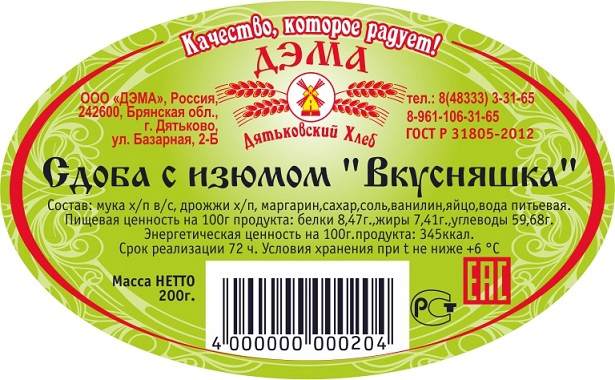

In [16]:
image = read_rgb_img('../sample_images/ru.6bea21ba-38e7-4170-9596-da06f73c3f37.jpg')
print(image.shape)
Image.fromarray(image)

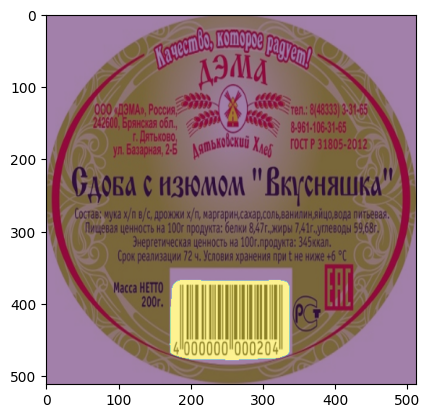

In [17]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


image = val_augmentation(image=image)['image']
img_np = image.astype(np.float32).transpose((2, 0, 1))
torch_input_tensor = torch.from_numpy(img_np)[None].to(DEVICE)
onnx_input_tensor = img_np[None]

# Выполняем инференс торчовой модели
with torch.no_grad():
    torch_output_tensor = model(torch_input_tensor)[0].cpu().detach().numpy()
    pred = sigmoid(torch_output_tensor)[0]
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    plt.imshow(image.astype(np.int32))
    plt.imshow(pred[0], alpha=0.5)

In [18]:
%%timeit
# Делаем замер времени инференса для торчовой модели
with torch.no_grad():
    torch_output_tensor = model(torch_input_tensor)[0].cpu().detach().numpy()

444 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# ONNX Runtime

In [19]:
# Доступные провайдеры, на которых можно выполнять вычисления
print(ort.get_available_providers())

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [20]:
# Инициализируем сессию

providers = [
    'CUDAExecutionProvider',
    'CPUExecutionProvider',
]

ort_session = ort.InferenceSession(
    ONNX_FILE,
    providers=providers
)

In [21]:
ort_inputs = {ort_session.get_inputs()[0].name: onnx_input_tensor}
print(list(ort_inputs.keys()))

['input']


In [22]:
# выполняем инференс ONNX Runtime
ort_outputs = ort_session.run(None, ort_inputs)[0]

In [23]:
%%timeit
# Делаем замер времени инференса для ONNX Runtime
# работаем быстрее чем торч - неплохо!
ort_outputs = ort_session.run(None, ort_inputs)[0]

32.5 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# провайдера можно поменять и после инициализации модели
ort_session.set_providers(['CPUExecutionProvider'])

In [25]:
%%timeit
ort_outputs = ort_session.run(None, ort_inputs)[0]

288 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# Сравниваем торчовой и ONNX Runtime моделей
# видим разницу только в 5 знаке после запятой
np.max(np.abs(torch_output_tensor - ort_outputs))

2.4795532e-05